In [ ]:
!pip install -q smolagents[toolkit]

In [ ]:
from smolagents import CodeAgent, WebSearchTool, TransformersModel

model = TransformersModel(
    model_id="HuggingFaceTB/SmolLM3-3B",
    max_new_tokens=4096,
    device_map="auto"
)

config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/182 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/289 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

In [ ]:
## we won't run this cell cuz it will try to allocate a lot of memory and we ll got "CUDA out of memory" error
agent = CodeAgent(tools=[WebSearchTool()], model=model, stream_outputs=True)

agent.run("How many seconds would it take for a leopard at full speed to run through Pont des Arts?")

> the expected output should be something like this : 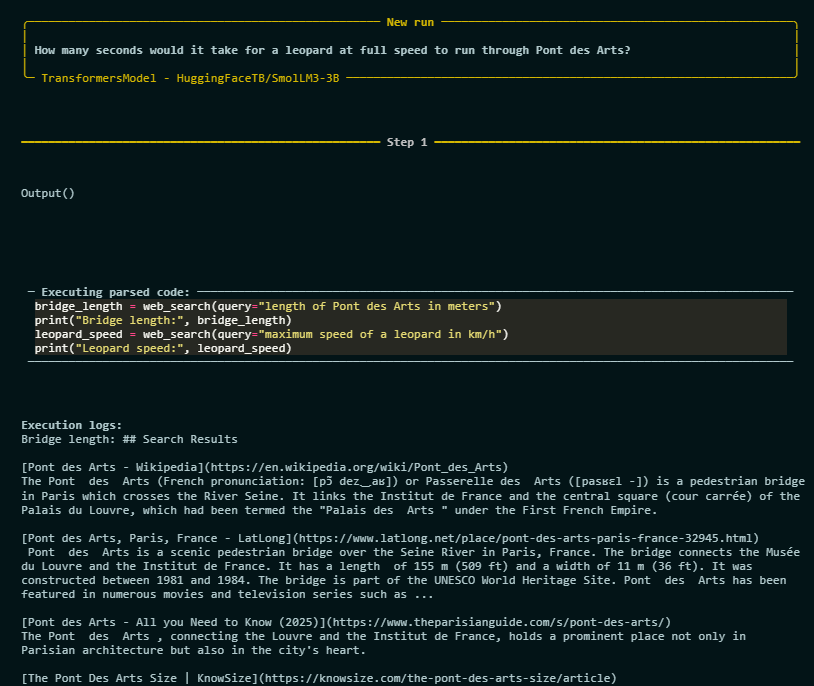

## Agentic RAG with Smollagents

In [ ]:
!git clone https://github.com/qdrant/qdrant

Cloning into 'qdrant'...
remote: Enumerating objects: 109783, done.
remote: Counting objects: 100% (1916/1916), done.
remote: Compressing objects: 100% (768/768), done.
remote: Total 109783 (delta 1528), reused 1208 (delta 1141), pack-reused 107867 (from 3)
Receiving objects: 100% (109783/109783), 39.65 MiB | 15.73 MiB/s, done.
Resolving deltas: 100% (80773/80773), done.


In [ ]:
!pip install -q "chonkie[qdrant]" "smolagents[openai]" pypdf 

In [ ]:
!pip install -qU langchain-qdrant langchain_openai
!pip install ddgs -q

In [ ]:
import os

from rich.markdown import Markdown
from rich.console import Console
from chonkie import TextChef, RecursiveChunker, QdrantHandshake

from smolagents import (
    tool,
    FinalAnswerTool,
    OpenAIServerModel,
    CodeAgent,
    InferenceClientModel
)
from huggingface_hub import notebook_login
from google.colab import userdata

from openai import OpenAI

from qdrant_client import QdrantClient

console = Console(width=88)

In [ ]:
# notebook_login()
from google.colab import userdata
HF_TOKEN= userdata.get('HF_TOKEN')

!hf auth login --token "$HF_TOKEN"

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `hf`CLI if you want to set the git credential as well.
Token is valid (permission: write).
The token `write_repo` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `write_repo`


## Ingesting the docs for search!

In [ ]:
# Get all the files in the Chonkie Repository for documentation!
files = []
for root, _, filenames in os.walk("/content/"):
    for filename in filenames:
        # if filename.endswith(".pdf"):
        if filename.endswith(".md") or filename.endswith(".mdx"):
            files.append(os.path.join(root, filename))

print(f"Found {len(files)} PDF Files in Chonkie!")

Found 20 PDF Files in Chonkie!


In [ ]:
# initiate chunker and handshake
chunker = RecursiveChunker(tokenizer="gpt2", chunk_size=512)
hs = QdrantHandshake(
    embedding_model="sentence-transformers/all-minilm-l6-v2",
    collection_name="github-docs"
)

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
from pypdf import PdfReader

for file_path in files:
    reader = PdfReader(file_path)
    full_text = ""
    for page in reader.pages:
        full_text += page.extract_text() + "\n"

    # Process with TextChef and chunk with RecursiveChunker
    # chef = TextChef()
    # doc = chef.chunk(full_text)
    chunks = chunker.chunk(full_text)

    # Write to Qdrant
    hs.write(chunks)
    print(f"Processed and ingested {file_path} with {len(chunks)} chunks.")

print("All specified PDF documents have been processed and ingested into Qdrant.")

Processed and ingested /content/track_2a.pdf with 2 chunks.
Processed and ingested /content/track3.pdf with 7 chunks.
Processed and ingested /content/track1.pdf with 2 chunks.
Processed and ingested /content/track_2b.pdf with 2 chunks.
All specified PDF documents have been processed and ingested into Qdrant.


In [ ]:
# Initializing the chef and run the pipeline on the files
chef = TextChef()
for file in files:
  doc = chef(file) # parse document
  chunks = chunker.chunk_document(doc) # chunk document
  hs.write(doc.chunks) # write document to vecotor db

### Add some tools

In [ ]:
@tool
def search_tool(query: str, limit: int = 1) -> str:
    """Uses semantic search over the documents in the current knowledge base.
    Args:
        query (str): The query to perform. This should be semantically close to your target documents. Ask proper questions instead of just key words.
        limit (int): The number of documents to return. Default is 1
    Returns:
        str: The retrieved documents.
    """
    response = hs.search(query, limit)
    docs = [f"CHUNK {i}: " + r["text"] for (i, r) in enumerate(response)]
    result = "\n\n".join(docs)
    return result

### InferenceClientModel :
The InferenceClientModel in smolagents wraps Hugging Face's InferenceClient to execute large language models (LLMs) through various inference providers available on the Hugging Face Hub.
 It supports providers such as Cerebras, Cohere, Fal, Fireworks, HF-Inference, Hyperbolic, Nebius, Novita, Replicate, SambaNova, Together, and more

In [ ]:
#initialize agent with one retriever tool
model = InferenceClientModel(model_id="deepseek-ai/DeepSeek-V3.2-Exp") # refer to the docs for more details https://huggingface.co/docs/smolagents/index
final_answer_tool=FinalAnswerTool()
agent = CodeAgent(
    tools=[search_tool, final_answer_tool],
    model=model,
    max_steps=10,
    verbosity_level=1,
)

In [ ]:
# run the agent on our query
# response = agent.run("How to chunk, refine and write to the Qdrant with Chonkie?")
response = agent.run("what is qdrant and how to start using it? ")
print(response)

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ what is qdrant and how to start using it?                                                                       │
│                                                                                                                 │
╰─ InferenceClientModel - deepseek-ai/DeepSeek-V3.2-Exp ──────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  qdrant_info = search_tool(query="What is Qdrant and how to start using it?", limit=3)                            
  print(qdrant_info)                                                                                               
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
CHUNK 0: 
- [Quick Start Guide](docs/QUICK_START.md)
- End to End [Colab 
Notebook](https://colab.research.google.com/drive/1Bz8RSVHwnNDaNtDwotfPj0w7AYzsdXZ-?usp=sharing) demo with 
SentenceBERT and Qdrant
- Detailed [Documentation](https://qdrant.tech/documentation/) are great starting points
- [Step-by-Step Tutorial](https://qdrant.to/qdrant-tutorial) to create your first neural network project with 
Qdrant

## Demo Projects<a href="https://replit.com/@qdrant"><img align="right" 
src="https://replit.com/badge/github/qdrant/qdrant" alt="Run on Repl.it"></a>

### Discover Semantic Text Search 🔍

Unlock the power of semantic embeddings with Qdrant, transcending keyword-based search to find meaningful 
connections in short texts. Deploy a neural search in minutes using a pre-trained neural network, and experience 
the future of text search. [Try it online!](https://qdrant.to/semantic-search-demo)

### Explore Similar Image Search - Food Discovery 🍕

There's more to discovery than text search, especially when it comes to food. People often choose meals based on 
appearance rather than descriptions and ingredients. Let Qdrant help your users find their next delicious meal 
using visual search, even if they don't know the dish's name. [Check it out!](https://qdrant.to/food-discovery)

### Master Extreme Classification - E-commerce Product Categorization 📺

Enter the cutting-edge realm of extreme classification, an emerging machine learning field tackling multi-class and
multi-label problems with millions of labels. Harness the potential of similarity learning models, and see how a 
pre-trained transformer model and Qdrant can revolutionize e-commerce product categorization. [Play with it 
online!](https://qdrant.to/extreme-classification-demo)

<details>
<summary> More solutions </summary>


CHUNK 1:     <a href="https://qdrant.to/roadmap"><img 
src="https://img.shields.io/badge/Roadmap-2025-bc1439.svg?style=flat-square" alt="Roadmap 2025"></a>
    <a href="https://cloud.qdrant.io/"><img 
src="https://img.shields.io/badge/Qdrant-Cloud-24386C.svg?logo=cloud&style=flat-square" alt="Qdrant Cloud"></a>
</p>

**Qdrant** (read: _quadrant_) is a vector similarity search engine and vector database.
It provides a production-ready service with a convenient API to store, search, and manage points—vectors with an 
additional payload
Qdrant is tailored to extended filtering support. It makes it useful for all sorts of neural-network or 
semantic-based matching, faceted search, and other applications.

Qdrant is written in Rust 🦀, which makes it fast and reliable even under high load. See 
[benchmarks](https://qdrant.tech/benchmarks/).

With Qdrant, embeddings or neural network encoders can be turned into full-fledged applications for matching, 
searching, recommending, and much more!

Qdrant is also available as a fully managed **[Qdrant Cloud](https://cloud.qdrant.io/)** ⛅ including a **free 
tier**.

<p align="center">
<strong><a href="docs/QUICK_START.md">Quick Start</a> • <a href="#clients">Client Libraries</a> • <a 
href="#demo-projects">Demo Projects</a> • <a href="#integrations">Integrations</a> • <a 
href="#contacts">Contact</a>

</strong>
</p>

## Getting Started

### Python

```
pip install qdrant-client
```

The python client offers a convenient way to start with Qdrant locally:

```python
from qdrant_client import QdrantClient


CHUNK 2: # Contributing to Qdrant
We love your input! We want to make contributing to this project as easy and transparent as possible, whether it's:

- Reporting a bug
- Discussing the current state of the code
- Submitting a fix
- Proposing new features

## We Develop with GitHub
We use github to host code, to track issues and feature requests, as well as accept pull requests.

## We Use [GitHub Flow](https://guides.github.com/introduction/flow/index.html), So All Code Changes Happen Through
Pull Requests
Pull requests are the best way to propose changes to the codebase (we use [GitHub 
Flo

[Step 1: Duration 3.61 seconds| Input tokens: 2,088 | Output tokens: 75]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  # Qdrant is a vector similarity search engine and vector database written in Rust                                
  # It provides API to store, search, and manage vectors with additional payload                                   
  # It's useful for neural-network matching, semantic search, faceted search, etc.                                 
                                                                                                                   
  # There are several ways to start using Qdrant:                                                                  
                                                                                                                   
  # 1. Python client (quick start for testing/prototyping)                                                         
  # 2. Docker container (full local deployment)                                                                    
  # 3. Qdrant Cloud (managed service with free tier)                                                               
                                                                                                                   
  final_answer("""Qdrant is a vector similarity search engine and vector database written in Rust. It provides a   
  production-ready service with a convenient API to store, search, and manage vectors with additional payload,     
  making it useful for neural-network matching, semantic search, faceted search, and other applications.           
                                                                                                                   
  To start using Qdrant:                                                                                           
                                                                                                                   
  1. **Quick Python Start** (for testing/prototyping):                                                             
     ```bash                                                                                                       
     pip install qdrant-client                                                                                     
     ```                                                                                                           
     ```python                                                                                                     
     from qdrant_client import QdrantClient                                                                        
                                                                                                                   
     # In-memory instance for testing                                                                              
     client = QdrantClient(":memory:")                                                                             
                                                                                                                   
     # Or local persistence for fast prototyping                                                                   
     client = QdrantClient(path="path/to/db")                                                                      
     ```                                                                                                           
                                                                                                                   
  2. **Local Deployment with Docker** (full features):                                                             
     ```bash                                                                                                       
     docker run -p 6333:6333 qdrant/qdrant                                                                         
     ```                                                 

Final answer: Qdrant is a vector similarity search engine and vector database written in Rust. It provides a 
production-ready service with a convenient API to store, search, and manage vectors with additional payload, making
it useful for neural-network matching, semantic search, faceted search, and other applications.

To start using Qdrant:

1. **Quick Python Start** (for testing/prototyping):
   ```bash
   pip install qdrant-client
   ```
   ```python
   from qdrant_client import QdrantClient
   
   # In-memory instance for testing
   client = QdrantClient(":memory:")
   
   # Or local persistence for fast prototyping
   client = QdrantClient(path="path/to/db")
   ```

2. **Local Deployment with Docker** (full features):
   ```bash
   docker run -p 6333:6333 qdrant/qdrant
   ```
   Then connect with any client:
   ```python
   client = QdrantClient("http://localhost:6333")
   ```

3. **Managed Service** (production):
   Use Qdrant Cloud (cloud.qdrant.io) which offers a free tier.

Qdrant also provides official client libraries for Go, Rust, JavaScript/TypeScript, Python, .NET/C#, and Java, with
community clients for Elixir, PHP, Ruby, and Java.

For detailed guidance, check the Quick Start Guide, documentation at qdrant.tech/documentation, or demo projects 
for specific use cases like semantic text search, image search, or e-commerce classification.

[Step 2: Duration 15.83 seconds| Input tokens: 6,533 | Output tokens: 563]

Qdrant is a vector similarity search engine and vector database written in Rust. It provides a production-ready service with a convenient API to store, search, and manage vectors with additional payload, making it useful for neural-network matching, semantic search, faceted search, and other applications.

To start using Qdrant:

1. **Quick Python Start** (for testing/prototyping):
   ```bash
   pip install qdrant-client
   ```
   ```python
   from qdrant_client import QdrantClient
   
   # In-memory instance for testing
   client = QdrantClient(":memory:")
   
   # Or local persistence for fast prototyping
   client = QdrantClient(path="path/to/db")
   ```

2. **Local Deployment with Docker** (full features):
   ```bash
   docker run -p 6333:6333 qdrant/qdrant
   ```
   Then connect with any client:
   ```python
   client = QdrantClient("http://localhost:6333")
   ```

3. **Managed Service** (production):
   Use Qdrant Cloud (cloud.qdrant.io) which offers a free tier.

Qdrant also pro

In [ ]:
console.print(Markdown(response))

Qdrant is a vector similarity search engine and vector database written in Rust. It     
provides a production-ready service with a convenient API to store, search, and manage  
vectors with additional payload, making it useful for neural-network matching, semantic 
search, faceted search, and other applications.                                         

To start using Qdrant:                                                                  

 1 Quick Python Start (for testing/prototyping):                                        
                                                                                        
    pip install qdrant-client                                                           
                                                                                        
                                                                                        
    from qdrant_client import QdrantClient                                              
                                                                                        
    # In-memory instance for testing                                                    
    client = QdrantClient(":memory:")                                                   
                                                                                        
    # Or local persistence for fast prototyping                                         
    client = QdrantClient(path="path/to/db")                                            
                                                                                        
 2 Local Deployment with Docker (full features):                                        
                                                                                        
    docker run -p 6333:6333 qdrant/qdrant                                               
                                                                                        
   Then connect with any client:                                                        
                                                                                        
    client = QdrantClient("http://localhost:6333")                                      
                                                                                        
 3 Managed Service (production): Use Qdrant Cloud (cloud.qdrant.io) which offers a free 
   tier.                                                                                

Qdrant also provides official client libraries for Go, Rust, JavaScript/TypeScript,     
Python, .NET/C#, and Java, with community clients for Elixir, PHP, Ruby, and Java.      

For detailed guidance, check the Quick Start Guide, documentation at                    
qdrant.tech/documentation, or demo projects for specific use cases like semantic text   
search, image search, or e-commerce classification.